In [1]:
# put download.sh and this notebook in the same folder on google drive. Remember to modify path!
from google.colab import drive
drive.mount('/content/gdrive')

import os

path = "/content/gdrive/MyDrive/DL_Project/Data"
os.chdir(path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import librosa
import os
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import csv
import torch.optim as optim
from tqdm import tqdm
from os.path import exists

# **FEATURE EXTRACTION**

In [3]:
configs = [
    [2048, 512, 2048],
    [2048, 512, 1024],
    [2048, 1024, 1024],
    [1024, 512, 1024],
    [1024, 256, 1024]
]

def process_data(personality_dir="Personality_Scores", metadata_dir="Metadata", audio_dir="Audio_clips"):
    df_personality = get_personality_scores(personality_dir)
    df_metadata = get_metadata(metadata_dir)
    df_feature = get_features(audio_dir)
    
    df = pd.merge(df_personality, df_metadata, left_on="Clip_ID", right_on="Clip_ID")
    df = pd.merge(df, df_feature, left_on="Clip_ID", right_on="Clip_ID")
    
    return df

def get_personality_scores(data_dir_path):
    df = pd.read_csv(data_dir_path + "/Score_011.csv")

    for i in range(1, 11):
        df_tmp = pd.read_csv(data_dir_path + f"/Score_0{i:02d}.csv")
        
        df["Extraversion"] = df["Extraversion"] + df_tmp["Extraversion"]
        df["Agreeableness"] = df["Agreeableness"] + df_tmp["Agreeableness"]
        df["Conscientiousness"] = df["Conscientiousness"] + df_tmp["Conscientiousness"]
        df["Neuroticism"] = df["Neuroticism"] + df_tmp["Neuroticism"]
        df["Openness"] = df["Openness"] + df_tmp["Openness"]

    df["Extraversion"] = df["Extraversion"] / 11
    df["Agreeableness"] = df["Agreeableness"] / 11
    df["Conscientiousness"] = df["Conscientiousness"] / 11
    df["Neuroticism"] = df["Neuroticism"] / 11
    df["Openness"] = df["Openness"] / 11
    
    return df

def get_metadata(data_dir_path):
    df = pd.read_csv(data_dir_path + "/Metadata.csv")
    return df

def get_features(data_dir_path):
    data = []
    
    for filename in os.listdir(data_dir_path):
        f = os.path.join(data_dir_path, filename)
        
        y, sr = librosa.load(f)
        output = []
        pad_len = 0
        for config in configs:
            s = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=config[0], hop_length=config[1], win_length=config[2])
            pad_len = max(pad_len, len(s[0]))
            output.append(s)
        
        for i, cur in enumerate(output):
            cur = np.pad(cur, ((0,0), (0, pad_len-len(cur[0]))))
            output[i] = cur
        output = np.array(output)

        data.append([filename.split(".")[0], output])
    
    df = pd.DataFrame(data, columns=["Clip_ID", "features"])
    return df


In [4]:
!pip3 install pickle5
import pickle5 as pickle

In [5]:
if exists("./processed_data.pkl"):
  with open("./processed_data.pkl", 'rb') as f:
    data = pickle.load(f)
else:
  ! bash download.sh
  data = process_data()
  data.to_pickle("processed_data.pkl")

# **HYPER PARAMETERS**

In [6]:
agg_type = 'numerical'
features = ['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']

if agg_type == 'numerical':
    agg = ''
else:
    agg = '_categorical'

batch_size = 4
lr = 2e-3
epochs = 200
cutoff = 0


# **DATA LOADER**

In [7]:
if agg_type=='numerical':
    data['Extraversion'] = np.where(data['Extraversion'] > cutoff,1,0)
    data['Agreeableness'] = np.where(data['Agreeableness'] > cutoff,1,0)
    data['Conscientiousness'] = np.where(data['Conscientiousness'] > cutoff,1,0)
    data['Neuroticism'] = np.where(data['Neuroticism'] > cutoff,1,0)
    data['Openness'] = np.where(data['Openness'] > cutoff,1,0)


In [8]:
#Split dataframe into train, validation, and test sets
train, val, test = np.split(
    data.sample(frac=1, random_state=101),
    [int(.7*len(data)), int(.85*len(data))]
)

In [9]:

class LibriSamplesTrain(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe.index)
    
    def __getitem__(self, ind):
        X = torch.Tensor(np.array(self.dataframe['features'].iloc[ind])) # 5 * 128 * T
        X = X.T # T * 128 * 5

        ys = [self.dataframe[f].iloc[ind] for f in features]
        Y = torch.Tensor(np.array(ys)) # 5
        return X, Y

    def collate_fn(batch):
        batch_x = [x[1::] for x,y in batch] # (B * T * 128 * 5)
        batch_y = [y for x,y in batch] # (B * 5)
        lengths_x = [x.shape[0] for x in batch_x]
        batch_x_pad = pad_sequence(batch_x, batch_first=True) # B, T(max time dimension in the batch), 128, 5
        
        lengths_y = [y.shape[0] for y in batch_y] 
        batch_y_pad = pad_sequence(batch_y, batch_first=True) # B * 5

        return batch_x_pad, batch_y_pad, torch.Tensor(lengths_x), torch.Tensor(lengths_y)

class LibriSamplesTest(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe.index)
    
    def __getitem__(self, ind):
        X = torch.Tensor(np.array(self.dataframe['features'].iloc[ind])) # T * 128 * 5
        return X

    def collate_fn(batch):
        batch_x = [x for x,y in batch] # (B * T * 128 * 5)

        lengths_x = [x.shape[0] for x in batch_x]
        batch_x_pad = pad_sequence(batch_x, batch_first=True) # B, T(max time dimension in the batch), 128, 5

        return batch_x_pad, torch.Tensor(lengths_x)


In [10]:
train_data = LibriSamplesTrain(train)
val_data = LibriSamplesTrain(val)
test_data = LibriSamplesTest(test)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True, collate_fn = LibriSamplesTrain.collate_fn)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size, shuffle=False, collate_fn = LibriSamplesTrain.collate_fn) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle=False, collate_fn = LibriSamplesTest.collate_fn) 

print("Batch size: ", batch_size)
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size:  4
Train dataset samples = 448, batches = 112
Val dataset samples = 96, batches = 24
Test dataset samples = 96, batches = 24


# **MODEL**

In [11]:
lstm_input = 512
lstm_hidden = 512
lstm_layers = 4
lstm_dropout = .1

In [12]:
class Network(nn.Module):

    def __init__(self):

        super(Network, self).__init__()
        
        self.embedding = nn.Sequential(
            nn.Conv2d(in_channels=5, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.Dropout2d(0.1),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.Dropout2d(0.1),
            nn.Conv2d(in_channels=128, out_channels=512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.GELU(),
        )

        self.lstm = nn.LSTM(input_size = lstm_input, hidden_size = lstm_hidden, dropout = lstm_dropout, bidirectional=True, batch_first = True)

        self.classification = nn.Sequential(
            nn.Linear(512*2, 1024),
            # nn.BatchNorm1d(2048),
            nn.GELU(),
            nn.Linear(1024, 512),
            # nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout2d(0.1),
            nn.Linear(512, 1),
        )

        self.avgpool_1 = nn.AdaptiveAvgPool2d((lstm_input, 1))
        self.avgpool_2 = nn.AdaptiveAvgPool2d((5, lstm_input))


    def forward(self, x):      
        x = x.transpose(1, 3) # B * 5 * 128 * T 
        x = self.embedding(x) # B * 512 * 128 * T
        x = x.transpose(1, 3) # B * T * 128 * 512
        x = self.avgpool_1(x).squeeze()
        x = self.avgpool_2(x)

        x, _ = self.lstm(x)
        # print(x.shape)
        x = self.classification(x) # B * num_class
        out = torch.sigmoid(x)
        out = out.squeeze()
        return out

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Network().to(device)
print(model)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Network(
  (embedding): Sequential(
    (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU()
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): GELU()
    (7): Dropout2d(p=0.1, inplace=False)
    (8): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): GELU()
  )
  (lstm): LSTM(512, 512, batch_first=True, dropout=0.1, bidirectional=True)
  (classification): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): GELU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): GELU()
    (4): Dropout2d(p=0.1, inpl

In [14]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=5e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.5)

# **TRAIN**

In [15]:
train_acc_list = list()
train_loss_list = list()
lr_list = list()
validation_acc_list = list()


train_separate_acc_list = list()
val_separate_acc_list = list()



print('train_loader: ', len(train_loader))

for epoch in range(epochs): #epochs

    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train') 
    total_loss = 0
    train_num_correct = 0

    train_separate_count = [0]*5

    #train
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad() 

        x, y, xlens, ylens = data
        x = x.to(device)
        y = y.to(device)

        output=model(x)
        
        prediction_out = (output>0.5).float()
        
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        train_num_correct += int((prediction_out==y).sum())
        
        total_loss += loss.item()
        # print("loss", loss.item())

        for i in range(len(prediction_out)):
            predict, real = prediction_out[i], y[i]
            for j in range(len(predict)):
                if int(predict[j]) == int(real[j]):
                    train_separate_count[j] = train_separate_count[j] + 1


        batch_bar.set_postfix(
          loss="{:.04f}".format(float(total_loss/(i+1)))
        )
        batch_bar.update()

        del x, y, output, prediction_out


    # torch.cuda.empty_cache()

    # validate
    model.eval()
    batch_bar.close()
    val_num_correct = 0

    val_separate_acc = 0
    val_separate_count = [0]*5

    for i, data in enumerate(val_loader):
        x, y, xlens, ylens = data
        x = x.to(device)
        y = y.to(device)

        val_outputs = model(x)
        prediction_val = (val_outputs>0.5).float()


        for i in range(len(prediction_val)):
            predict, real = prediction_val[i], y[i]
            for j in range(len(predict)):
                if int(predict[j]) == int(real[j]):
                    val_separate_count[j] = val_separate_count[j] + 1

        val_num_correct += int((prediction_val==y).sum())

        del x, y, val_outputs, prediction_val

        
    # torch.cuda.empty_cache()


    train_acc = 100 * (train_num_correct/5) / (len(train_loader) * batch_size)
    train_loss = float(total_loss / len(train_loader))
    lr = float(optimizer.param_groups[0]['lr'])
    validation_acc = 100 * (val_num_correct/5) / (len(val_loader)*batch_size)
    
    # validation_acc = 100 * val_num_correct / (len(val_loader)*batch_size)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    lr_list.append(lr)
    validation_acc_list.append(validation_acc)


    train_separate_acc = 100 * np.array(train_separate_count) / (len(train_loader)*batch_size)
    train_separate_acc_list.append(train_separate_acc)


    val_separate_acc = 100 * np.array(val_separate_count) / (len(val_loader)*batch_size)
    val_separate_acc_list.append(val_separate_acc)


    print("Epoch {}/{}: Train Acc {:.04f}%, Train Loss {}, Learning Rate {}, Val Acc {:.04f}%".format(
        epoch + 1,
        epochs,
        train_acc,
        train_loss,
        lr,
        validation_acc,
        ))


    scheduler.step()

torch.cuda.empty_cache()

train_loader:  112


Train:   0%|          | 0/112 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/200: Train Acc 68.3929%, Train Loss 0.6119056085922888, Learning Rate 0.002, Val Acc 74.3750%


Epoch 2/200: Train Acc 71.1161%, Train Loss 0.5850103045148509, Learning Rate 0.002, Val Acc 66.8750%


Epoch 3/200: Train Acc 71.8750%, Train Loss 0.5681728159210512, Learning Rate 0.002, Val Acc 74.5833%


Epoch 4/200: Train Acc 72.6786%, Train Loss 0.5659193625407559, Learning Rate 0.002, Val Acc 75.8333%


Epoch 5/200: Train Acc 72.9464%, Train Loss 0.5524217741830009, Learning Rate 0.002, Val Acc 74.1667%


Epoch 6/200: Train Acc 72.4554%, Train Loss 0.5594761435474668, Learning Rate 0.002, Val Acc 75.0000%


Epoch 7/200: Train Acc 72.7232%, Train Loss 0.545456886557596, Learning Rate 0.002, Val Acc 74.7917%


Epoch 8/200: Train Acc 74.1964%, Train Loss 0.5319225459492632, Learning Rate 0.002, Val Acc 75.8333%


Epoch 9/200: Train Acc 72.4554%, Train Loss 0.5528761494372573, Learning Rate 0.002, Val Acc 74.7917%


Epoch 10/200: Train Acc 74.0625%, Train Loss 0.5320439624733159, Learning Rate 0.002, Val Acc 74.5833%


Epoch 11/200: Train Acc 76.1161%, Train Loss 0.5092482114476817, Learning Rate 0.001, Val Acc 75.4167%


Epoch 12/200: Train Acc 77.3214%, Train Loss 0.4775747514462897, Learning Rate 0.001, Val Acc 74.7917%


Epoch 13/200: Train Acc 78.7054%, Train Loss 0.46179173288068603, Learning Rate 0.001, Val Acc 71.0417%


Epoch 14/200: Train Acc 80.5357%, Train Loss 0.42718026587473495, Learning Rate 0.001, Val Acc 72.5000%


Epoch 15/200: Train Acc 82.3661%, Train Loss 0.40259171762902823, Learning Rate 0.001, Val Acc 70.8333%


Epoch 16/200: Train Acc 82.7679%, Train Loss 0.37924888104732546, Learning Rate 0.001, Val Acc 74.7917%


Epoch 17/200: Train Acc 83.7946%, Train Loss 0.34484282288966434, Learning Rate 0.001, Val Acc 70.8333%


Epoch 18/200: Train Acc 86.2946%, Train Loss 0.30197792160989984, Learning Rate 0.001, Val Acc 74.3750%


Epoch 19/200: Train Acc 87.5446%, Train Loss 0.2757509308201926, Learning Rate 0.001, Val Acc 71.4583%


Epoch 20/200: Train Acc 90.7589%, Train Loss 0.2201871757362304, Learning Rate 0.001, Val Acc 71.6667%


Epoch 21/200: Train Acc 91.3839%, Train Loss 0.18922697788886061, Learning Rate 0.0005, Val Acc 71.8750%


Epoch 22/200: Train Acc 92.5893%, Train Loss 0.15225725652583474, Learning Rate 0.0005, Val Acc 72.2917%


Epoch 23/200: Train Acc 94.0625%, Train Loss 0.1306290016343285, Learning Rate 0.0005, Val Acc 72.2917%


Epoch 24/200: Train Acc 95.1786%, Train Loss 0.10877486297041676, Learning Rate 0.0005, Val Acc 72.5000%


Epoch 25/200: Train Acc 93.5714%, Train Loss 0.12933650486333395, Learning Rate 0.0005, Val Acc 72.2917%


Epoch 26/200: Train Acc 95.1786%, Train Loss 0.09856138500150077, Learning Rate 0.0005, Val Acc 72.7083%


Epoch 27/200: Train Acc 96.2054%, Train Loss 0.07815064265891383, Learning Rate 0.0005, Val Acc 73.5417%


Epoch 28/200: Train Acc 95.1339%, Train Loss 0.08794958696038131, Learning Rate 0.0005, Val Acc 72.7083%


Epoch 29/200: Train Acc 96.1161%, Train Loss 0.08534163973057828, Learning Rate 0.0005, Val Acc 70.6250%


Epoch 30/200: Train Acc 95.7143%, Train Loss 0.09071589222029226, Learning Rate 0.0005, Val Acc 73.3333%


Epoch 31/200: Train Acc 96.6071%, Train Loss 0.06021700357327323, Learning Rate 0.00025, Val Acc 72.5000%


Epoch 32/200: Train Acc 96.7411%, Train Loss 0.05919557351012372, Learning Rate 0.00025, Val Acc 72.0833%


Epoch 33/200: Train Acc 96.5625%, Train Loss 0.0676559496327757, Learning Rate 0.00025, Val Acc 72.7083%


Epoch 34/200: Train Acc 95.2232%, Train Loss 0.08521752340152489, Learning Rate 0.00025, Val Acc 71.0417%


Epoch 35/200: Train Acc 95.7143%, Train Loss 0.0780501318781676, Learning Rate 0.00025, Val Acc 72.5000%


Epoch 36/200: Train Acc 96.9643%, Train Loss 0.05524425497969787, Learning Rate 0.00025, Val Acc 72.7083%


Epoch 37/200: Train Acc 96.3839%, Train Loss 0.0679127833450447, Learning Rate 0.00025, Val Acc 72.2917%


Epoch 38/200: Train Acc 96.6518%, Train Loss 0.06222896747040961, Learning Rate 0.00025, Val Acc 72.5000%


Epoch 39/200: Train Acc 95.6696%, Train Loss 0.08618971546506161, Learning Rate 0.00025, Val Acc 73.5417%


Epoch 40/200: Train Acc 95.5804%, Train Loss 0.07615874515394287, Learning Rate 0.00025, Val Acc 72.2917%


Epoch 41/200: Train Acc 96.0268%, Train Loss 0.0749960234971679, Learning Rate 0.000125, Val Acc 73.1250%


Epoch 42/200: Train Acc 96.8750%, Train Loss 0.054848085504969744, Learning Rate 0.000125, Val Acc 73.3333%


Epoch 43/200: Train Acc 95.6696%, Train Loss 0.07038033048425518, Learning Rate 0.000125, Val Acc 72.5000%


Epoch 44/200: Train Acc 95.7143%, Train Loss 0.08023073001244743, Learning Rate 0.000125, Val Acc 72.5000%


Epoch 45/200: Train Acc 96.2500%, Train Loss 0.06997046690927229, Learning Rate 0.000125, Val Acc 72.5000%


Epoch 46/200: Train Acc 95.3125%, Train Loss 0.08027104197489214, Learning Rate 0.000125, Val Acc 72.9167%


Epoch 47/200: Train Acc 96.8750%, Train Loss 0.05357756367947023, Learning Rate 0.000125, Val Acc 72.0833%


Epoch 48/200: Train Acc 96.5179%, Train Loss 0.06636216063533798, Learning Rate 0.000125, Val Acc 71.2500%


Epoch 49/200: Train Acc 96.2946%, Train Loss 0.060870093936927105, Learning Rate 0.000125, Val Acc 72.2917%


Epoch 50/200: Train Acc 96.2946%, Train Loss 0.06576281400028604, Learning Rate 0.000125, Val Acc 72.2917%


Epoch 51/200: Train Acc 95.6250%, Train Loss 0.07009020881257097, Learning Rate 6.25e-05, Val Acc 71.8750%


Epoch 52/200: Train Acc 96.4286%, Train Loss 0.061018790541770125, Learning Rate 6.25e-05, Val Acc 71.6667%


Epoch 53/200: Train Acc 96.2054%, Train Loss 0.06591099414354724, Learning Rate 6.25e-05, Val Acc 72.0833%


Epoch 54/200: Train Acc 95.5804%, Train Loss 0.06759742279859486, Learning Rate 6.25e-05, Val Acc 72.2917%


Epoch 55/200: Train Acc 96.1161%, Train Loss 0.07366733151554732, Learning Rate 6.25e-05, Val Acc 71.8750%


Epoch 56/200: Train Acc 96.2500%, Train Loss 0.06996004659887944, Learning Rate 6.25e-05, Val Acc 72.0833%


Epoch 57/200: Train Acc 96.4732%, Train Loss 0.06896313203832298, Learning Rate 6.25e-05, Val Acc 72.0833%


Epoch 58/200: Train Acc 95.2679%, Train Loss 0.08596241200384165, Learning Rate 6.25e-05, Val Acc 71.6667%


Epoch 59/200: Train Acc 96.6518%, Train Loss 0.06727809242043595, Learning Rate 6.25e-05, Val Acc 71.8750%


Epoch 60/200: Train Acc 96.5625%, Train Loss 0.061723635490356595, Learning Rate 6.25e-05, Val Acc 71.8750%


Epoch 61/200: Train Acc 95.6250%, Train Loss 0.07448170681704523, Learning Rate 3.125e-05, Val Acc 71.4583%


Epoch 62/200: Train Acc 96.2946%, Train Loss 0.05764509897984941, Learning Rate 3.125e-05, Val Acc 71.8750%


Epoch 63/200: Train Acc 95.8929%, Train Loss 0.06947224243103685, Learning Rate 3.125e-05, Val Acc 72.0833%


Epoch 64/200: Train Acc 95.7143%, Train Loss 0.08132089010283446, Learning Rate 3.125e-05, Val Acc 71.8750%


Epoch 65/200: Train Acc 96.7857%, Train Loss 0.06286570924215036, Learning Rate 3.125e-05, Val Acc 71.4583%


Epoch 66/200: Train Acc 96.6964%, Train Loss 0.060742727337412816, Learning Rate 3.125e-05, Val Acc 71.0417%


Epoch 67/200: Train Acc 95.2679%, Train Loss 0.08049053054084052, Learning Rate 3.125e-05, Val Acc 71.6667%


Epoch 68/200: Train Acc 94.5982%, Train Loss 0.09474193573106707, Learning Rate 3.125e-05, Val Acc 71.2500%


Epoch 69/200: Train Acc 95.7589%, Train Loss 0.07759512635091934, Learning Rate 3.125e-05, Val Acc 71.4583%


Epoch 70/200: Train Acc 95.4018%, Train Loss 0.07216666405838623, Learning Rate 3.125e-05, Val Acc 71.2500%


Epoch 71/200: Train Acc 96.1161%, Train Loss 0.06606309127527002, Learning Rate 1.5625e-05, Val Acc 71.4583%


Epoch 72/200: Train Acc 96.2500%, Train Loss 0.06448600241710827, Learning Rate 1.5625e-05, Val Acc 71.4583%


Epoch 73/200: Train Acc 95.5804%, Train Loss 0.0711137539993949, Learning Rate 1.5625e-05, Val Acc 71.6667%


Epoch 74/200: Train Acc 97.0536%, Train Loss 0.05826109464473867, Learning Rate 1.5625e-05, Val Acc 71.6667%


Epoch 75/200: Train Acc 95.4911%, Train Loss 0.07752490872777733, Learning Rate 1.5625e-05, Val Acc 71.6667%


Epoch 76/200: Train Acc 96.7857%, Train Loss 0.07260483986610618, Learning Rate 1.5625e-05, Val Acc 71.6667%


Epoch 77/200: Train Acc 95.9821%, Train Loss 0.07490781763498891, Learning Rate 1.5625e-05, Val Acc 71.4583%


Epoch 78/200: Train Acc 95.8482%, Train Loss 0.0711608202996205, Learning Rate 1.5625e-05, Val Acc 71.6667%


Epoch 79/200: Train Acc 94.6429%, Train Loss 0.09077711780711338, Learning Rate 1.5625e-05, Val Acc 71.6667%


Epoch 80/200: Train Acc 96.0268%, Train Loss 0.06951037108315765, Learning Rate 1.5625e-05, Val Acc 71.6667%


Epoch 81/200: Train Acc 96.3393%, Train Loss 0.07162662556187627, Learning Rate 7.8125e-06, Val Acc 71.2500%


Epoch 82/200: Train Acc 95.5357%, Train Loss 0.07714101167624676, Learning Rate 7.8125e-06, Val Acc 71.4583%


Epoch 83/200: Train Acc 95.6696%, Train Loss 0.07177011485421556, Learning Rate 7.8125e-06, Val Acc 71.2500%


Epoch 84/200: Train Acc 96.6518%, Train Loss 0.05885598289750606, Learning Rate 7.8125e-06, Val Acc 71.6667%


Epoch 85/200: Train Acc 97.5446%, Train Loss 0.05090763541543554, Learning Rate 7.8125e-06, Val Acc 71.6667%


Epoch 86/200: Train Acc 95.7143%, Train Loss 0.07396931089016943, Learning Rate 7.8125e-06, Val Acc 71.4583%


Epoch 87/200: Train Acc 96.2054%, Train Loss 0.06941402444701746, Learning Rate 7.8125e-06, Val Acc 71.2500%


Epoch 88/200: Train Acc 96.1161%, Train Loss 0.06346617658401296, Learning Rate 7.8125e-06, Val Acc 71.2500%


Epoch 89/200: Train Acc 97.1875%, Train Loss 0.05455165173538238, Learning Rate 7.8125e-06, Val Acc 71.4583%


Epoch 90/200: Train Acc 96.2500%, Train Loss 0.06963683698877178, Learning Rate 7.8125e-06, Val Acc 71.4583%


Epoch 91/200: Train Acc 95.6250%, Train Loss 0.07442989897605758, Learning Rate 3.90625e-06, Val Acc 71.4583%


Epoch 92/200: Train Acc 96.1161%, Train Loss 0.0724891834140318, Learning Rate 3.90625e-06, Val Acc 71.4583%


Epoch 93/200: Train Acc 96.1161%, Train Loss 0.05615833865952645, Learning Rate 3.90625e-06, Val Acc 71.4583%


Epoch 94/200: Train Acc 95.0893%, Train Loss 0.08712726846716785, Learning Rate 3.90625e-06, Val Acc 71.4583%


Epoch 95/200: Train Acc 95.8036%, Train Loss 0.07481014672067994, Learning Rate 3.90625e-06, Val Acc 71.6667%


Epoch 96/200: Train Acc 96.6964%, Train Loss 0.060523428575220146, Learning Rate 3.90625e-06, Val Acc 71.4583%


Epoch 97/200: Train Acc 96.2054%, Train Loss 0.06328519410856107, Learning Rate 3.90625e-06, Val Acc 71.4583%


Epoch 98/200: Train Acc 97.2768%, Train Loss 0.05468472233269089, Learning Rate 3.90625e-06, Val Acc 71.4583%


Epoch 99/200: Train Acc 96.6964%, Train Loss 0.059573239472927204, Learning Rate 3.90625e-06, Val Acc 71.4583%


Epoch 100/200: Train Acc 96.7411%, Train Loss 0.06203876952962365, Learning Rate 3.90625e-06, Val Acc 71.6667%


Epoch 101/200: Train Acc 96.1607%, Train Loss 0.0581596778959254, Learning Rate 1.953125e-06, Val Acc 71.4583%


Epoch 102/200: Train Acc 97.0089%, Train Loss 0.05487514792801968, Learning Rate 1.953125e-06, Val Acc 71.4583%


Epoch 103/200: Train Acc 95.8036%, Train Loss 0.07726526460876114, Learning Rate 1.953125e-06, Val Acc 71.4583%


Epoch 104/200: Train Acc 95.4018%, Train Loss 0.07163401032665424, Learning Rate 1.953125e-06, Val Acc 71.4583%


Epoch 105/200: Train Acc 95.8036%, Train Loss 0.07604507164411485, Learning Rate 1.953125e-06, Val Acc 71.4583%


Epoch 106/200: Train Acc 96.8304%, Train Loss 0.06075248928307429, Learning Rate 1.953125e-06, Val Acc 71.4583%


Epoch 107/200: Train Acc 95.8036%, Train Loss 0.07611004418194511, Learning Rate 1.953125e-06, Val Acc 71.4583%


Epoch 108/200: Train Acc 95.4464%, Train Loss 0.08456916435317753, Learning Rate 1.953125e-06, Val Acc 71.4583%


Epoch 109/200: Train Acc 96.3393%, Train Loss 0.05984647575579061, Learning Rate 1.953125e-06, Val Acc 71.4583%


Epoch 110/200: Train Acc 95.3571%, Train Loss 0.08455932584187968, Learning Rate 1.953125e-06, Val Acc 71.4583%


Epoch 111/200: Train Acc 95.0446%, Train Loss 0.08093119488386336, Learning Rate 9.765625e-07, Val Acc 71.4583%


Epoch 112/200: Train Acc 95.6250%, Train Loss 0.07410367789509564, Learning Rate 9.765625e-07, Val Acc 71.4583%


Epoch 113/200: Train Acc 96.0714%, Train Loss 0.07497589519549917, Learning Rate 9.765625e-07, Val Acc 71.4583%


Epoch 114/200: Train Acc 95.6250%, Train Loss 0.07292901830810397, Learning Rate 9.765625e-07, Val Acc 71.4583%


Epoch 115/200: Train Acc 95.9821%, Train Loss 0.06936413363427262, Learning Rate 9.765625e-07, Val Acc 71.6667%


Epoch 116/200: Train Acc 97.0982%, Train Loss 0.05319198272802542, Learning Rate 9.765625e-07, Val Acc 71.6667%


Epoch 117/200: Train Acc 96.1607%, Train Loss 0.07090871853051997, Learning Rate 9.765625e-07, Val Acc 71.6667%


Epoch 118/200: Train Acc 95.6696%, Train Loss 0.07636407984297122, Learning Rate 9.765625e-07, Val Acc 71.6667%


Epoch 119/200: Train Acc 96.2946%, Train Loss 0.06759710163346203, Learning Rate 9.765625e-07, Val Acc 71.4583%


Epoch 120/200: Train Acc 95.9821%, Train Loss 0.06896226704544059, Learning Rate 9.765625e-07, Val Acc 71.6667%


Epoch 121/200: Train Acc 95.5357%, Train Loss 0.07941091332903584, Learning Rate 4.8828125e-07, Val Acc 71.4583%


Epoch 122/200: Train Acc 96.8750%, Train Loss 0.05932382891651855, Learning Rate 4.8828125e-07, Val Acc 71.8750%


Epoch 123/200: Train Acc 96.8750%, Train Loss 0.05263106030359462, Learning Rate 4.8828125e-07, Val Acc 71.4583%


Epoch 124/200: Train Acc 97.1429%, Train Loss 0.05719614907781028, Learning Rate 4.8828125e-07, Val Acc 71.4583%


Epoch 125/200: Train Acc 96.2500%, Train Loss 0.06602603857829235, Learning Rate 4.8828125e-07, Val Acc 71.4583%


Epoch 126/200: Train Acc 96.1607%, Train Loss 0.06422199938953099, Learning Rate 4.8828125e-07, Val Acc 71.4583%


Epoch 127/200: Train Acc 96.0268%, Train Loss 0.06705782642380395, Learning Rate 4.8828125e-07, Val Acc 71.4583%


Epoch 128/200: Train Acc 96.2946%, Train Loss 0.07074228043361533, Learning Rate 4.8828125e-07, Val Acc 71.4583%


Epoch 129/200: Train Acc 95.6696%, Train Loss 0.07406102848538255, Learning Rate 4.8828125e-07, Val Acc 71.4583%


Epoch 130/200: Train Acc 96.6071%, Train Loss 0.06016708962475344, Learning Rate 4.8828125e-07, Val Acc 71.4583%


Epoch 131/200: Train Acc 95.8036%, Train Loss 0.06994559775586343, Learning Rate 2.44140625e-07, Val Acc 71.6667%


Epoch 132/200: Train Acc 95.9375%, Train Loss 0.07419254365676917, Learning Rate 2.44140625e-07, Val Acc 71.8750%


Epoch 133/200: Train Acc 96.3839%, Train Loss 0.06856592728274993, Learning Rate 2.44140625e-07, Val Acc 71.4583%


Epoch 134/200: Train Acc 95.7143%, Train Loss 0.07326434033193559, Learning Rate 2.44140625e-07, Val Acc 71.4583%


Epoch 135/200: Train Acc 95.7143%, Train Loss 0.07568805090757788, Learning Rate 2.44140625e-07, Val Acc 71.6667%


Epoch 136/200: Train Acc 97.4554%, Train Loss 0.05209929469961594, Learning Rate 2.44140625e-07, Val Acc 71.4583%


Epoch 137/200: Train Acc 96.6964%, Train Loss 0.05669536927309642, Learning Rate 2.44140625e-07, Val Acc 71.4583%


Epoch 138/200: Train Acc 96.8750%, Train Loss 0.05548304370868858, Learning Rate 2.44140625e-07, Val Acc 71.4583%


Epoch 139/200: Train Acc 96.7411%, Train Loss 0.057372462635642406, Learning Rate 2.44140625e-07, Val Acc 71.4583%


Epoch 140/200: Train Acc 96.0714%, Train Loss 0.07060156777609652, Learning Rate 2.44140625e-07, Val Acc 71.4583%


Epoch 141/200: Train Acc 96.7411%, Train Loss 0.058311460954404835, Learning Rate 1.220703125e-07, Val Acc 71.4583%


Epoch 142/200: Train Acc 96.2500%, Train Loss 0.06758707749071087, Learning Rate 1.220703125e-07, Val Acc 71.2500%


Epoch 143/200: Train Acc 96.2946%, Train Loss 0.06528993130279, Learning Rate 1.220703125e-07, Val Acc 71.4583%


Epoch 144/200: Train Acc 96.6964%, Train Loss 0.0644338858562118, Learning Rate 1.220703125e-07, Val Acc 71.6667%


Epoch 145/200: Train Acc 96.2500%, Train Loss 0.06968291780588005, Learning Rate 1.220703125e-07, Val Acc 71.6667%


Epoch 146/200: Train Acc 96.2500%, Train Loss 0.06503395419684109, Learning Rate 1.220703125e-07, Val Acc 71.4583%


Epoch 147/200: Train Acc 95.0446%, Train Loss 0.08524887973341931, Learning Rate 1.220703125e-07, Val Acc 71.4583%


Epoch 148/200: Train Acc 95.6250%, Train Loss 0.07333371526224093, Learning Rate 1.220703125e-07, Val Acc 71.4583%


Epoch 149/200: Train Acc 95.7589%, Train Loss 0.07032121140652338, Learning Rate 1.220703125e-07, Val Acc 71.4583%


Epoch 150/200: Train Acc 96.9643%, Train Loss 0.05535925400137793, Learning Rate 1.220703125e-07, Val Acc 71.6667%


Epoch 151/200: Train Acc 97.0982%, Train Loss 0.05108906579282646, Learning Rate 6.103515625e-08, Val Acc 71.4583%


Epoch 152/200: Train Acc 96.6964%, Train Loss 0.05753341337755761, Learning Rate 6.103515625e-08, Val Acc 71.6667%


Epoch 153/200: Train Acc 95.8036%, Train Loss 0.06573300372214876, Learning Rate 6.103515625e-08, Val Acc 71.6667%


Epoch 154/200: Train Acc 96.0268%, Train Loss 0.06815371514586602, Learning Rate 6.103515625e-08, Val Acc 71.4583%


Epoch 155/200: Train Acc 95.1786%, Train Loss 0.08440068405408852, Learning Rate 6.103515625e-08, Val Acc 71.2500%


Epoch 156/200: Train Acc 96.8304%, Train Loss 0.056937369733654056, Learning Rate 6.103515625e-08, Val Acc 71.6667%


Epoch 157/200: Train Acc 96.9196%, Train Loss 0.05313537248796, Learning Rate 6.103515625e-08, Val Acc 71.4583%


Epoch 158/200: Train Acc 95.5357%, Train Loss 0.07470714161870566, Learning Rate 6.103515625e-08, Val Acc 71.4583%


Epoch 159/200: Train Acc 95.5804%, Train Loss 0.07650981339383277, Learning Rate 6.103515625e-08, Val Acc 71.2500%


Epoch 160/200: Train Acc 96.7857%, Train Loss 0.05197125010526297, Learning Rate 6.103515625e-08, Val Acc 71.4583%


Epoch 161/200: Train Acc 96.2500%, Train Loss 0.06156457091566076, Learning Rate 3.0517578125e-08, Val Acc 71.4583%


Epoch 162/200: Train Acc 95.5804%, Train Loss 0.0721191893588318, Learning Rate 3.0517578125e-08, Val Acc 71.4583%


Epoch 163/200: Train Acc 95.4911%, Train Loss 0.07113158361437806, Learning Rate 3.0517578125e-08, Val Acc 71.4583%


Epoch 164/200: Train Acc 95.1339%, Train Loss 0.07989638917780541, Learning Rate 3.0517578125e-08, Val Acc 71.4583%


Epoch 165/200: Train Acc 96.6964%, Train Loss 0.05494766253360644, Learning Rate 3.0517578125e-08, Val Acc 71.4583%


Epoch 166/200: Train Acc 95.7589%, Train Loss 0.0660526597155321, Learning Rate 3.0517578125e-08, Val Acc 71.6667%


Epoch 167/200: Train Acc 96.1607%, Train Loss 0.07125152301972244, Learning Rate 3.0517578125e-08, Val Acc 71.4583%


Epoch 168/200: Train Acc 96.3839%, Train Loss 0.06535869462538153, Learning Rate 3.0517578125e-08, Val Acc 71.4583%


Epoch 169/200: Train Acc 97.0089%, Train Loss 0.05241566082224632, Learning Rate 3.0517578125e-08, Val Acc 71.4583%


Epoch 170/200: Train Acc 96.4286%, Train Loss 0.0646064429465574, Learning Rate 3.0517578125e-08, Val Acc 71.4583%


Epoch 171/200: Train Acc 97.0982%, Train Loss 0.05380474163085377, Learning Rate 1.52587890625e-08, Val Acc 71.4583%


Epoch 172/200: Train Acc 95.2679%, Train Loss 0.08000891652752884, Learning Rate 1.52587890625e-08, Val Acc 71.6667%


Epoch 173/200: Train Acc 96.5625%, Train Loss 0.06958853317293899, Learning Rate 1.52587890625e-08, Val Acc 71.4583%


Epoch 174/200: Train Acc 96.2054%, Train Loss 0.06508390097528911, Learning Rate 1.52587890625e-08, Val Acc 71.6667%


Epoch 175/200: Train Acc 96.4286%, Train Loss 0.06275741130849914, Learning Rate 1.52587890625e-08, Val Acc 71.4583%


Epoch 176/200: Train Acc 96.3839%, Train Loss 0.0666718731059096, Learning Rate 1.52587890625e-08, Val Acc 71.4583%


Epoch 177/200: Train Acc 94.7321%, Train Loss 0.08847958342540961, Learning Rate 1.52587890625e-08, Val Acc 71.4583%


Epoch 178/200: Train Acc 96.6071%, Train Loss 0.06137838421750733, Learning Rate 1.52587890625e-08, Val Acc 71.4583%


Epoch 179/200: Train Acc 95.7589%, Train Loss 0.07749156625508899, Learning Rate 1.52587890625e-08, Val Acc 71.8750%


Epoch 180/200: Train Acc 96.1607%, Train Loss 0.06776355695153516, Learning Rate 1.52587890625e-08, Val Acc 71.4583%


Epoch 181/200: Train Acc 96.3839%, Train Loss 0.05728451404408678, Learning Rate 7.62939453125e-09, Val Acc 71.4583%


Epoch 182/200: Train Acc 97.2321%, Train Loss 0.054393820522772786, Learning Rate 7.62939453125e-09, Val Acc 71.4583%


Epoch 183/200: Train Acc 96.6071%, Train Loss 0.06371309654035377, Learning Rate 7.62939453125e-09, Val Acc 71.4583%


Epoch 184/200: Train Acc 95.8929%, Train Loss 0.07883069701051275, Learning Rate 7.62939453125e-09, Val Acc 71.4583%


Epoch 185/200: Train Acc 95.3125%, Train Loss 0.0741933102836571, Learning Rate 7.62939453125e-09, Val Acc 71.4583%


Epoch 186/200: Train Acc 95.9821%, Train Loss 0.07293255492317233, Learning Rate 7.62939453125e-09, Val Acc 71.4583%


Epoch 187/200: Train Acc 96.5179%, Train Loss 0.05611698307523584, Learning Rate 7.62939453125e-09, Val Acc 71.4583%


Epoch 188/200: Train Acc 97.1875%, Train Loss 0.04885617118212439, Learning Rate 7.62939453125e-09, Val Acc 71.4583%


Epoch 189/200: Train Acc 95.3571%, Train Loss 0.07164979590862076, Learning Rate 7.62939453125e-09, Val Acc 71.6667%


Epoch 190/200: Train Acc 94.8214%, Train Loss 0.088894784027888, Learning Rate 7.62939453125e-09, Val Acc 71.4583%


Epoch 191/200: Train Acc 96.2054%, Train Loss 0.07001176347489693, Learning Rate 3.814697265625e-09, Val Acc 71.4583%


Epoch 192/200: Train Acc 96.9196%, Train Loss 0.061448346884926, Learning Rate 3.814697265625e-09, Val Acc 71.4583%


Epoch 193/200: Train Acc 95.3125%, Train Loss 0.07904073968878984, Learning Rate 3.814697265625e-09, Val Acc 71.4583%


Epoch 194/200: Train Acc 95.5804%, Train Loss 0.07762653037683671, Learning Rate 3.814697265625e-09, Val Acc 71.4583%


Epoch 195/200: Train Acc 95.2232%, Train Loss 0.08253287366835137, Learning Rate 3.814697265625e-09, Val Acc 71.4583%


Epoch 196/200: Train Acc 95.8929%, Train Loss 0.07228086905923144, Learning Rate 3.814697265625e-09, Val Acc 71.4583%


Epoch 197/200: Train Acc 97.9018%, Train Loss 0.04182147527836325, Learning Rate 3.814697265625e-09, Val Acc 71.8750%


Epoch 198/200: Train Acc 96.4732%, Train Loss 0.06306200141719387, Learning Rate 3.814697265625e-09, Val Acc 71.6667%


Epoch 199/200: Train Acc 96.5625%, Train Loss 0.0663323002860677, Learning Rate 3.814697265625e-09, Val Acc 71.4583%


Epoch 200/200: Train Acc 95.6696%, Train Loss 0.0719105102571709, Learning Rate 3.814697265625e-09, Val Acc 71.4583%


In [16]:
train_acc_arr = np.array(train_acc_list)
val_acc_arr = np.array(validation_acc_list)
train_loss_arr = np.array(train_loss_list)
lr_arr = np.array(lr_list)
train_acc_arr_comined = np.array(train_separate_acc_list)
val_acc_arr_comined = np.array(val_separate_acc_list)


results_df = pd.DataFrame({'epoch_number': np.arange(epochs), #epochs
                      'train_accuracy': train_acc_arr,
                      'validation_accuracy': val_acc_arr,
                      'train_loss': train_loss_arr,
                      'learning_rate': lr_arr,
                      'train_accuracy_Extraversion': train_acc_arr_comined[:,0],
                      'train_accuracy_Agreeableness': train_acc_arr_comined[:,1],
                      'train_accuracy_Conscientiousness': train_acc_arr_comined[:,2],
                      'train_accuracy_Neuroticism': train_acc_arr_comined[:,3],
                      'train_accuracy_Openness': train_acc_arr_comined[:,4],
                      'validation_accuracy_Extraversion': val_acc_arr_comined[:,0],
                      'validation_accuracy_Agreeableness': val_acc_arr_comined[:,1],
                      'validation_accuracy_Conscientiousness': val_acc_arr_comined[:,2],
                      'validation_accuracy_Neuroticism': val_acc_arr_comined[:,3],
                      'validation_accuracy_Openness': val_acc_arr_comined[:,4],
                      })

results_df.to_csv('results_cnn_lstm.csv', index=False)



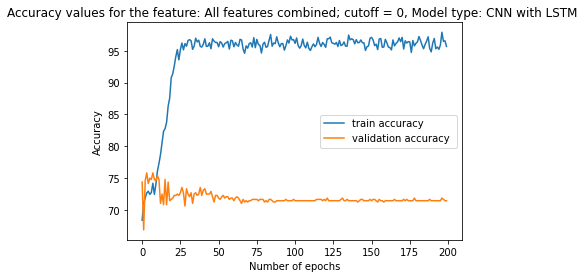

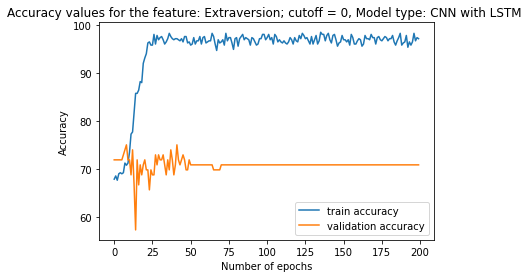

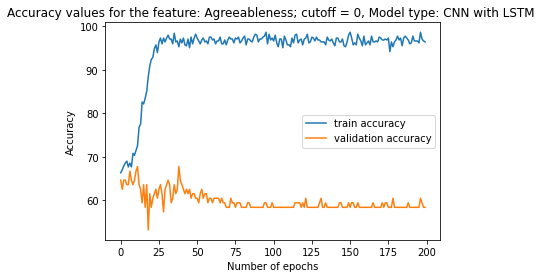

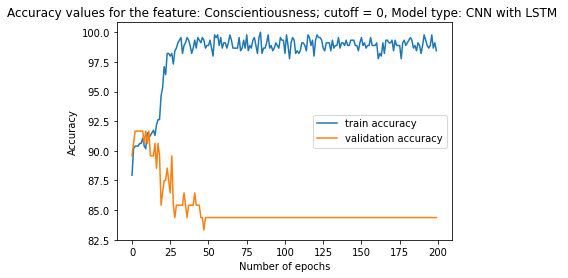

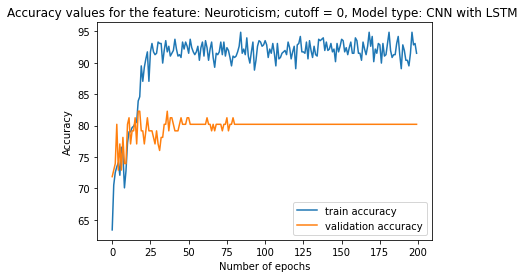

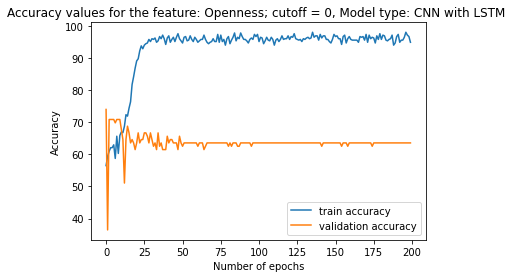

In [18]:
import matplotlib.pyplot as plt

model_type = "CNN with LSTM"

#features = [Extraversion, Agreeableness, Conscientiousness, Neuroticism, Openness]

results_df = pd.read_csv("results_cnn_lstm.csv", header = 0)

plt.plot(results_df['train_accuracy'], label="train accuracy")
plt.plot(results_df['validation_accuracy'], label="validation accuracy ")
plt.title(f"Accuracy values for the feature: All features combined; cutoff = {cutoff}, Model type: {model_type} ")
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend()
plt.show()

for i in range(5):
    plt.plot(results_df['train_accuracy_' + str(features[i])], label="train accuracy")
    plt.plot(results_df['validation_accuracy_' + str(features[i])], label="validation accuracy")
    plt.title(f"Accuracy values for the feature: {str(features[i])}; cutoff = {cutoff}, Model type: {model_type} ")
    plt.ylabel('Accuracy')
    plt.xlabel('Number of epochs')
    plt.legend()
    plt.show()

